# Example use of the Sonic module Nodosus.jl

See https://julialang.org, https://juliadb.org and https://juliastats.org for reference.

In [1]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


In [2]:
import Dates, JuliaDB, Random, StatsPlots

In [3]:
using StatsPlots
ENV["GKSwstype"] = "100"
gr(fmt = :png)

Plots.GRBackend()

Get secret token,

In [4]:
include("../src/LinckiiSecrets.jl")
secret = LinckiiSecrets.keab

(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

In [5]:
include("../src/Linckii.jl")
include("../src/Nodosus.jl")

Main.Nodosus

Load site,

In [6]:
@time site = Linckii.loadsite(secret, :nodes, :devices, :sensors)
map(length, site)

 27.611258 seconds (24.89 M allocations: 1.673 GiB, 1.61% gc time)


(nodes = 279, devices = 11, sensors = 175)

Specify patterns,

In [7]:
p, q = Dates.Minute(15), Dates.Minute(4 * 4 * 15)
pp0 = rows -> Nodosus.preprocess0(rows, p, q)
pp1 = rows -> Nodosus.preprocess1(rows, p, q)
pp2 = rows -> Nodosus.preprocess2(rows, p, q)
patterns = Dict(
    4 => Dict(
        :meter_effect           => pp1,
        :meter_heatenergy       => pp2,
        :meter_primreturntemp   => pp1,
        :meter_primsupplytemp   => pp1,
        :meter_volume           => pp2,
        :meter_volumeflow       => pp1,
        :outdoortemp            => pp1,
        :outdoortemp_offset     => pp0,
    ),
    6 => Dict(
        :cloudiness             => pp1,
        :outdoortemp            => pp1,
        :wind_direction         => pp1,
        :wind_speed             => pp1,
    ),
)

Dict{Int64,Dict{Symbol,V} where V} with 2 entries:
  4 => Dict{Symbol,Function}(:meter_primreturntemp=>#9,:meter_effect=>#9,:outdo…
  6 => Dict(:cloudiness=>#9,:outdoortemp=>#9,:wind_direction=>#9,:wind_speed=>#…

Get pattern nodes,

In [8]:
rs = JuliaDB.rows(Linckii.get_pattern_nodes(patterns; site...))
if true
    rs = [(node_id = 62, device_id = 4), (node_id = 93, device_id = 4)] # [rs[Random.rand(1 : end)]]
end

2-element Array{NamedTuple{(:node_id, :device_id),Tuple{Int64,Int64}},1}:
 (node_id = 62, device_id = 4)
 (node_id = 93, device_id = 4)

Save data,

In [9]:
@time for r in rs
    p = Linckii.urlpath(secret)
    p = Linckii.db_path(p, "data"; db = r.node_id)
    try
        r_pattern = patterns[r.device_id]
        r_d1 = Linckii.loaddata(secret, r.node_id, keys(r_pattern))
        r_d2 = Nodosus.preprocess(r_d1, r_pattern)
        r_d3 = JuliaDB.unstack(r_d2)
        JuliaDB.save(r_d3, p)
        println("$(p): Done")
    catch e
        println("$(p): $(e)")
    end
end

db/linckii/~keab/data/62.db: Done
db/linckii/~keab/data/93.db: Done
 85.938973 seconds (206.42 M allocations: 9.165 GiB, 3.31% gc time)


Random choice,

In [10]:
r = rs[Random.rand(1 : end)]

(node_id = 93, device_id = 4)

Load data,

In [11]:
p = Linckii.urlpath(secret)
p = Linckii.db_path(p, "data"; db = r.node_id)
data = JuliaDB.load(p)

Table with 56458 rows, 9 columns:
Columns:
#  colname               type
────────────────────────────────────────────────
1  datetime              DateTime
2  meter_effect          Union{Missing, Float64}
3  meter_heatenergy      Union{Missing, Float64}
4  meter_primreturntemp  Union{Missing, Float64}
5  meter_primsupplytemp  Union{Missing, Float64}
6  meter_volume          Union{Missing, Float64}
7  meter_volumeflow      Union{Missing, Float64}
8  outdoortemp           Union{Missing, Float64}
9  outdoortemp_offset    Union{Missing, Float64}

Simple graphics,

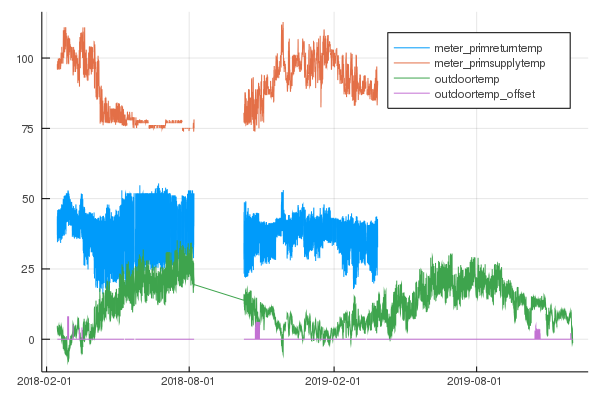

In [12]:
@df data plot(:datetime, [:meter_primreturntemp :meter_primsupplytemp :outdoortemp :outdoortemp_offset])

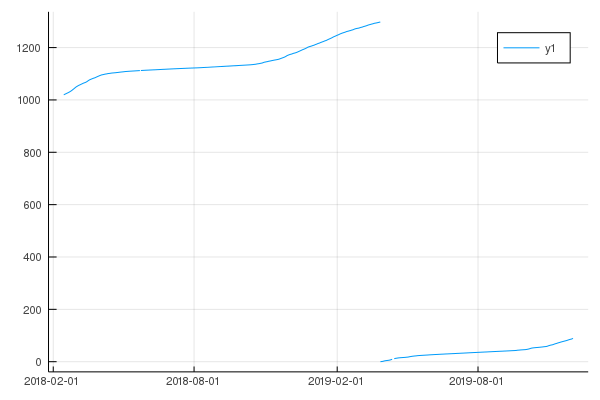

In [13]:
@df data plot(:datetime, [:meter_heatenergy])

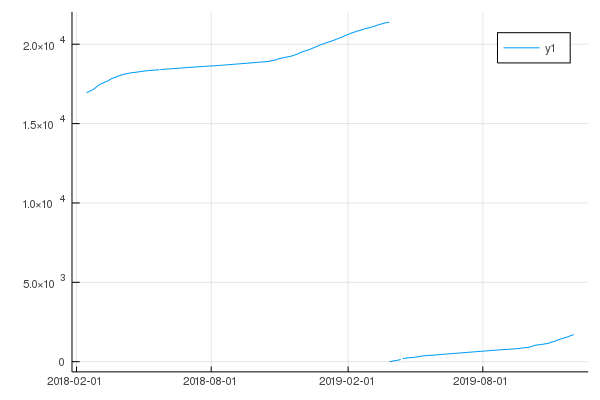

In [14]:
@df data plot(:datetime, [:meter_volume])